In [196]:
import pandas as pd
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [264]:
IN_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv"
df = pd.read_csv(IN_PATH, sep="\t")

df["date"] = pd.to_datetime(df["date"])
df = df.dropna(subset=["date"])


#only keep data 
#first day of local coverage in our data, 4/1
firstLocDate = min(df.loc[df["national"] == False, "date"])

#clusteredDates = df[["clustNum", "date"]].groupby(by="clustNum").agg(list).reset_index()
#clusteredDates["minDate"] = clusteredDates["date"].apply(lambda x: min(x))
#keepClusts = clusteredDates.loc[clusteredDates["minDate"] >= firstLocDate, "clustNum"]
#df = df[df["clustNum"].isin(keepClusts)]

df = df[df["date"] > firstLocDate]
len(df)


<ipython-input-264-2e04705d9462>:2: DtypeWarning: Columns (2,3,10,11,13,14,17,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(IN_PATH, sep="\t")


2065826

In [321]:
[item[-30:] for item in list(df[df["clustNum"] == 7].sample(20)["content"])]

[' insightful Thomas Paine @ @ @',
 ' pandemic at kycovid19.ky.gov.',
 'y what is right with America .',
 'ess Daily Updates, click here.',
 'our civil liberties or not .\n”',
 't was updated with further @ @',
 'surging cases in the country .',
 " and incapable of healing . ''",
 'Pfizer shot by @ @ @ @ @ @ @ .',
 's and loosen @ @ @ @ @ gauge .',
 'd they – can do a lot better .',
 '.com .\nThank you for reading .',
 "starvation , '' Beasley said .",
 'ment , with regard to Durham @',
 'nterested ?\nShare this story !',
 's that make each other worse."',
 'e Democratic nominee tweeted .',
 'se visit www.covidawaremn.com.',
 ' most popular products today !',
 'orable food .\nStock up today !']

In [265]:
longClusts = df[["clustNum","date"]].groupby("clustNum").agg(list)

In [266]:
def numDays(inList): 
    return (max(inList) - min(inList)) / timedelta(hours=24)

longClusts["clustLength"] = longClusts["date"].apply(numDays)
longClusts["numStories"] = longClusts["date"].apply(len)

In [267]:
longClusts = longClusts[(longClusts["clustLength"] > 5) & (longClusts["clustLength"] < 5000)].reset_index()

In [268]:
longClusts = df[df["clustNum"].isin(longClusts["clustNum"].unique())]

In [269]:
dateDf = longClusts[["source", "date", "clustNum"]].sort_values("date")
#dateDf = dateDf.set_index("source")
dateDf["count"] = 1
#dateDf = dateDf.groupby("date").agg({"count":sum, "source":list})
#.groupby(by=["source", "clustNum"]).rolling(window=3, on="date").agg(list) #.sum()

#for source in dateDf.index.unique(): 
#    sDf = dateDf.loc[dateDf["source"] == "source"]
    

In [270]:
#within each outlet, get the 3 day rolling window of coverage 
timeRolling = dateDf.drop(columns="clustNum").groupby(by=["source", "date"]).agg(sum)\
.reset_index().groupby("source").rolling("3D", on="date").sum() #.rolling("3D", on="date").sum()
timeRolling = timeRolling.reset_index().drop(columns=["level_1"])

In [271]:
len(timeRolling)

101431

In [272]:
#quick sanity check 
len(dateDf.drop_duplicates(subset=["source", "date"]))

101431

In [273]:
timeRollingClust = dateDf.groupby(["source", "clustNum", "date"]).sum()\
.reset_index().groupby(["source", "clustNum"]).rolling("3D", on="date").sum()

timeRollingClust = timeRollingClust.reset_index().drop(columns=["level_2"])

In [274]:
len(timeRollingClust)

471901

In [275]:
len(timeRollingClust.drop_duplicates(subset=["source", "clustNum", "date"]))

471901

Text(0.5, 1.0, '# number of articles in our 3 day rolling windows at outlet level')

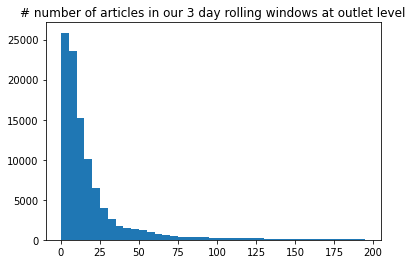

In [276]:
plt.hist(timeRolling["count"], bins=np.arange(0, 200, 5))
plt.title("# number of articles in our 3 day rolling windows at outlet level")

Text(0.5, 1.0, '# number of articles in our 3 day rolling windows at outlet,cluster level')

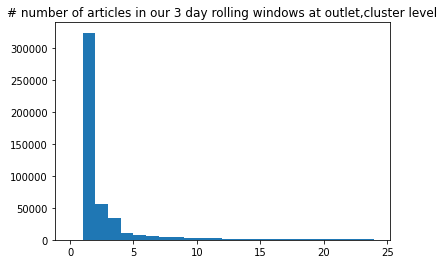

In [277]:
plt.hist(timeRollingClust["count"], bins=np.arange(0, 25, 1))
plt.title("# number of articles in our 3 day rolling windows at outlet,cluster level")
#interpretation: for most stories, outlets report a very small amount on that story in a 3 day window 

(0.0, 10000.0)

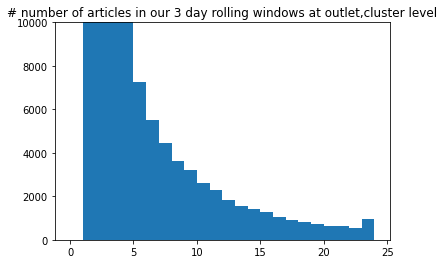

In [279]:
#zoom in on figure above 
plt.hist(timeRollingClust["count"], bins=np.arange(0, 25, 1))
plt.title("# number of articles in our 3 day rolling windows at outlet,cluster level")

plt.ylim(0, 10000)

In [280]:
#sanity check, what are the clusters where we have lots of reporting? 
timeRollingClust[timeRollingClust["source"]=="washingtonpost"].sort_values("count", ascending=False)

,source,clustNum,date,count
445849,washingtonpost,7.0,2020-06-28,286.0
445848,washingtonpost,7.0,2020-06-27,192.0
445839,washingtonpost,7.0,2020-06-18,109.0
445850,washingtonpost,7.0,2020-06-30,105.0
445838,washingtonpost,7.0,2020-06-17,95.0
...,...,...,...,...
446802,washingtonpost,19287.0,2020-06-27,1.0
446801,washingtonpost,19287.0,2020-05-01,1.0
446800,washingtonpost,19243.0,2020-06-15,1.0
446799,washingtonpost,19243.0,2020-06-02,1.0


In [220]:
#weird, same content from ap but different title
rapidCityClust = df.loc[df["clustNum"] == 161285.0, ["title", "content", "source"]]

In [228]:
#almost all of the same articles but with different headlines.. hmm 
vdareClusts = df.loc[df["clustNum"] == 156332.0, ["title", "content", "source", "date"]]

In [231]:
#the sun media storming about I'm a celebrity? 
imACeleb = df.loc[df["clustNum"] == 2596.0, ["title", "content", "source", "date"]]

In [235]:
#cnn and nashville explosion
#cnn had 3 day rolling of 14
nashvilleExplosion = df.loc[df["clustNum"] == 1462.0, ["title", "content", "source", "date"]]

In [245]:
#india china standoff
#WaPo had 7 over 3 day rolling window 
indiaChina = df.loc[df["clustNum"] == 4714.0, ["title", "content", "source", "date"]]

In [247]:
#WaPo had 7 over 3 day rolling window on Kamala Harris birth claims 
kamalaBirthClaims = df.loc[df["clustNum"] == 1623.0, ["title", "content", "source", "date"]]

In [325]:
#now we have the 3 day windows where we get total coverage and coverage for each cluster 
stormDf = pd.merge(timeRolling, timeRollingClust.rename(columns={"count":"clustCount"}), on=["source", "date"])

stormDf["reportingPercent"] = (stormDf["clustCount"] / stormDf["count"]) * 100

In [326]:
#sort storm df so we get the largest three day window for an outlet,cluster appearing first
stormDf = stormDf.sort_values(["source", "clustNum", "reportingPercent"], ascending=False)

stormDf = stormDf.drop_duplicates(["source", "clustNum"], keep="first")

In [330]:
stormDf = stormDf[stormDf["count"] >= 20]

<Axes: xlabel='reportingPercent', ylabel='Density'>

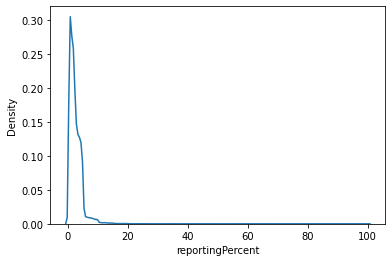

In [418]:
sns.kdeplot(x="reportingPercent", data=stormDf)

Text(0.5, 1.0, 'empirical CDF of percentage of coverage dedicated to a given story')

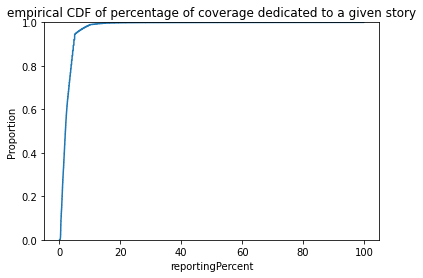

In [332]:
#is there an inflection point here maybe??? 
sns.ecdfplot(x="reportingPercent", data=stormDf)
plt.title("empirical CDF of percentage of coverage dedicated to a given story")

In [347]:
#checking some examples 
stormDf[stormDf["reportingPercent"] >= 20].sample(15)

,source,date,count,clustNum,clustCount,reportingPercent
70572,dailybeast,2020-10-23,37.0,10988.0,8.0,21.621622
402864,thetelegraph,2020-11-28,248.0,192.0,60.0,24.193548
258898,southfront,2020-09-13,40.0,8051.0,8.0,20.000000
25036,birminghammail,2020-06-19,70.0,11232.0,15.0,21.428571
197580,newyorkpost,2020-11-11,22.0,7.0,14.0,63.636364
239162,rferl,2020-10-12,23.0,65747.0,5.0,21.739130
319787,thegatewaypundit,2020-12-06,40.0,7.0,33.0,82.500000
276478,tass,2020-08-07,49.0,7800.0,10.0,20.408163
19738,bbc,2020-11-26,22.0,665.0,8.0,36.363636
50779,chicagosuntimes,2020-11-29,24.0,506.0,5.0,20.833333


In [346]:
#russian hacking 
#14% of yahoo news at peak 
df.loc[(df["clustNum"] == 21620.0) & (df["source"] == "yahoonews"), ["title", "content", "source"]]

#17% of abcnews at peak - Daniel Prude spit hood story 
df.loc[(df["clustNum"] == 1763.0) & (df["source"] == "abcnews"), ["title", "content", "source"]]

#FALSE POSITIVE - a bunch of boston herald stories about covid 
df.loc[(df["clustNum"] == 2959.0) & (df["source"] == "bostonherald"), ["title", "content", "source", "date"]]

#the hill reports about Jerry Falwell tweet  
#only 5 total stories though... 
df.loc[(df["clustNum"] == 9242.0) & (df["source"] == "thehill"), ["title", "content", "source", "date"]]

#the telegraph reporting on black friday and cyber monday 
df.loc[(df["clustNum"] == 192.0) & (df["source"] == "thetelegraph"), ["title", "content", "source", "date"]]
list(df.loc[(df["clustNum"] == 192.0) & (df["source"] == "thetelegraph")].sample(20)["title"])

,title,content,source,date
1887070,"Black staff, athletes leave Liberty University...",A number of Black staff members and student-at...,thehill,2020-06-24
1887560,Prominent conservatives question Jerry Falwell...,"Jerry Falwell Jr. , the president of Liberty U...",thehill,2020-08-04
1887573,Falwell Jr. apologizes for viral vacation phot...,Liberty University President Jerry Falwell Jr....,thehill,2020-08-06
1887583,GOP congressman calls for Falwell's resignation,Rep. Mark Walker Bradley ( Mark ) Mark WalkerP...,thehill,2020-08-06
1887593,Jerry Falwell Jr. placed on indefinite leave,"Jerry Falwell Jr. , president and chancellor o...",thehill,2020-08-07
1887901,Liberty University announces investigation int...,Liberty University announced Monday that it is...,thehill,2020-08-31


In [367]:
# so let's say that the cutoff is around 10 percent 
stormDf["isStorm"] = stormDf["reportingPercent"] >= 10

<ipython-input-367-3ff3af142be1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stormDf["isStorm"] = stormDf["reportingPercent"] >= 10


In [380]:
storyStormDf = stormDf[["clustNum","isStorm"]].groupby("clustNum").agg([np.mean, sum]) #.rename(columns={"reportingPercent":"outletStormPercent"})

In [381]:
storyStormDf.columns = storyStormDf.columns.droplevel()
storyStormDf = storyStormDf.reset_index()

In [473]:
storyStormDf = storyStormDf.rename(columns={"mean":"average_reporting_percent", "sum":"outlets_over_cutoff"})

In [475]:
storyStormDf[storyStormDf["outlets_over_cutoff"] >= 3]

,clustNum,average_reporting_percent,outlets_over_cutoff
0,0.0,0.055556,3
1,1.0,0.148936,14
2,7.0,1.000000,57
8,29.0,0.180556,13
11,44.0,0.156863,8
...,...,...,...
10650,48922.0,0.428571,3
11260,52286.0,0.115385,3
15727,79378.0,0.150000,3
18407,97432.0,0.100000,3


In [476]:
pd.merge(df, storyStormDf, on="clustNum", how="right")

,Unnamed: 0,key,local_id,sourcedomain_id,date,title,content,url,fips,source,...,national,id,author,published,published_utc,collection_utc,year,clustNum,average_reporting_percent,outlets_over_cutoff
0,12619,12619,newyorkobserver--2020-04-07--Prince Harry and ...,newyorkobserver-observer.com,2020-04-07,Prince Harry and Meghan Are Keeping Busy While...,The Duke and Duchess of Sussex made their move...,https://observer.com/2020/04/prince-harry-megh...,36061.0,newyorkobserver,...,False,NaN,NaN,NaN,NaN,NaN,2020,0.0,0.055556,3
1,28945,28945,newyorkobserver--2020-04-14--Prince Harry Is H...,newyorkobserver-observer.com,2020-04-14,Prince Harry Is Having Trouble Adjusting to Hi...,The Duke and Duchess of Sussex officially move...,https://observer.com/2020/04/prince-harry-megh...,36061.0,newyorkobserver,...,False,NaN,NaN,NaN,NaN,NaN,2020,0.0,0.055556,3
2,43496,43496,dailyherald--2020-04-20--Harry and Meghan say ...,dailyherald-dailyherald.com,2020-04-20,Harry and Meghan say they won't cooperate with...,LONDON -- The Duke and Duchess of Sussex say t...,http://www.dailyherald.com/article/20200420/bu...,17031.0,dailyherald,...,False,NaN,NaN,NaN,NaN,NaN,2020,0.0,0.055556,3
3,43909,43909,murrysvillestar--2020-04-20--Harry and Meghan ...,murrysvillestar-triblive.com,2020-04-20,Harry and Meghan say they won’t cooperate with...,LONDON — The Duke and Duchess of Sussex say th...,https://triblive.com/news/world/harry-and-megh...,42129.0,murrysvillestar,...,False,NaN,NaN,NaN,NaN,NaN,2020,0.0,0.055556,3
4,43933,43933,pittsburghtribunereview--2020-04-20--Harry and...,pittsburghtribunereview-triblive.com,2020-04-20,Harry and Meghan say they won’t cooperate with...,LONDON — The Duke and Duchess of Sussex say th...,https://triblive.com/news/world/harry-and-megh...,42003.0,pittsburghtribunereview,...,False,NaN,NaN,NaN,NaN,NaN,2020,0.0,0.055556,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
625815,1166318,1948674,NaN,NaN,2020-09-13,New Thrift Shop Supported by Subscriptions and...,"Kutkat , 32 , who was sitting at a sewing mach...",https://www.usnews.com/news/best-states/oregon...,NaN,usnews,...,True,usnews--2020-09-13--New Thrift Shop Supported ...,Associated Press,"Sun, 13 Sep 2020 05:01:13 GMT",1.599988e+09,1.600004e+09,2020,209375.0,0.000000,0
625816,329791,329791,newyorkobserver--2020-08-09--National Museum o...,newyorkobserver-observer.com,2020-08-09,National Museum of Women in the Arts to Host W...,"If an artist doesn’t have a Wikipedia page, do...",https://observer.com/2020/08/wikipedia-edit-a-...,36061.0,newyorkobserver,...,False,NaN,NaN,NaN,NaN,NaN,2020,209379.0,0.000000,0
625817,455126,455126,waterburyrepublicanamerican--2020-10-01--Matta...,waterburyrepublicanamerican-rep-am.com,2020-10-01,Mattatuck hosts Art and Feminism Wikipedia edi...,Mattatuck Museum in Waterbury will host a virt...,https://www.rep-am.com/life-arts/arts/2020/10/...,9009.0,waterburyrepublicanamerican,...,False,NaN,NaN,NaN,NaN,NaN,2020,209379.0,0.000000,0
625818,2289977,3072333,NaN,NaN,2020-10-31,Bedding sets are more than half off at Macy's ...,— Recommendations are independently chosen by ...,https://feeds.feedblitz.com/~/638044654/0/usat...,NaN,usatoday,...,True,usatoday--2020-10-31--Bedding sets are more th...,"Melissa Lee, Reviewed.com","Sat, 31 Oct 2020 17:11:33 +0000",1.604179e+09,1.604199e+09,2020,209395.0,0.000000,0


<Axes: xlabel='sum', ylabel='Count'>

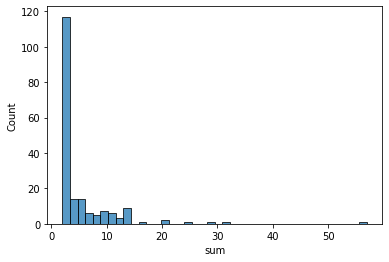

In [385]:
sns.histplot(x="sum", data=storyStormDf[storyStormDf["sum"] > 1])

In [395]:
#when we have at least three outlets on board 
stormClusts = list(storyStormDf.loc[storyStormDf["sum"] >= 3, "clustNum"])
stormClusts.remove(7)

In [422]:
#112 storm clusters
len(stormClusts)

112

In [408]:
import random
stormSample = random.sample(stormClusts, 5)
stormSample

[313.0, 443.0, 982.0, 8956.0, 514.0]

In [464]:
#313 doesn't seem quite right.. 
stormArticles = df[df["clustNum"] == 195]

In [465]:
"""
It seems like right now the storms are either too mixed, about the same general them but not really the same event, 
or it's debatable. For example, with Trans people in sports you wonder if that should be one storm or not
"""
#0: WRONG, Same Issue Diff. Events: Trump, Prince Harry, Meghan Markle, Privacy 
#1: DECENT: Trump banning TikTok, seems decent 
#29: Bubba Wallace story and additional angles 
#44: contested votes in Belarus and ensuing crackdowns 
#76: WRONG: premier league news, but not specific to an event 
#89: NO GREAT: U.S. ships coming near Iran, Iran launches military satellite around same time
#97: Trans issues, especially Trans people in sports 
#141: Trump using illegal funds for border wall, Steve Bannon Arrested about it 
#153: Felon's voting in Florida 
#192: NOT GREAT - Black Friday, Tech Reviews, Cyber Monday, Apple 
#195: Tennis - clearly multiple clusters are merged I think

"\nIt seems like right now the storms are either too mixed, about the same general them but not really the same event, \nor it's debatable. For example, with Trans people in sports you wonder if that should be one storm or not\n"

In [470]:
"""
for i, item in stormArticles.sample(20).sort_values("date").iterrows(): 
    print(item["date"])
    print(item["title"])
    print(item["content"][:300])
    print("-----------------------------")
"""

'\nfor i, item in stormArticles.sample(20).sort_values("date").iterrows(): \n    print(item["date"])\n    print(item["title"])\n    print(item["content"][:300])\n    print("-----------------------------")\n'

In [469]:
stormArticles

Index(['Unnamed: 0', 'key', 'local_id', 'sourcedomain_id', 'date', 'title',
       'content', 'url', 'fips', 'source', 'description', 'onlinesince',
       'rank', 'state', 'city', 'lon', 'lat', 'county', 'total_population',
       'white_pct', 'black_pct', 'hispanic_pct', 'nonwhite_pct',
       'foreignborn_pct', 'female_pct', 'age29andunder_pct',
       'age65andolder_pct', 'median_hh_inc', 'clf_unemploy_pct', 'lesshs_pct',
       'lesscollege_pct', 'lesshs_whites_pct', 'lesscollege_whites_pct',
       'rural_pct', 'ruralurban_cc', 'predrt_0', 'predrt_12', 'predrt_3',
       'national', 'id', 'author', 'published', 'published_utc',
       'collection_utc', 'year', 'clustNum'],
      dtype='object')